In [672]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Construct Survey Correction Function

This is done for a single QPM mock here

Define correction factor as:
$\Phi(r_a,\mu_c) = \frac{4\pi V (\bar n\bar w)^2r_a^2\Delta r\delta \mu}{RR_a^c}$
in angular bin $c$, radial bin $a$.

#### Load in galaxy data-set to estimate $\bar n$, $\bar w$ and $V$.

In [2]:
gal_file = '/mnt/store1/oliverphilcox/DR12_QPM/processed/qpm_galaxy_1.xyzwj'
all_gal = np.loadtxt(gal_file)

In [3]:
gal_x = all_gal[:,0]
gal_y = all_gal[:,1]
gal_z = all_gal[:,2]
gal_w = all_gal[:,3]

In [4]:
N_gal = len(all_gal)
w_bar = mean(gal_w)

Find volume via ConvexHull

In [5]:
import scipy.spatial as ss
hull = ss.ConvexHull(np.vstack([gal_x,gal_y,gal_z]).T)
print('volume inside points is: ',hull.volume)
V=hull.volume # in (Mpc/h)^3

volume inside points is:  4039684687.8916426


In [6]:
n_bar = N_gal/V

#### Survey normalization

In [7]:
norm = 4.*pi*(n_bar*w_bar)*V
print(norm)

1352595.0688298931


#### Define bin widths and central radii

In [477]:
m = 100

In [478]:
mu_cen = np.arange(1/(2*m),1+1/(2*m),1/m)

In [528]:
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/PowerSpectra/radial_binning_fine.csv')[3:]
r_cen = mean(r_bins,axis=1)
delta_r = r_cen[-1]-r_cen[-2]
mu_cen = np.arange(1/(2*m),1.+1/(2*m),1/m)
delta_mu = mu_cen[-1]-mu_cen[-2]
n=len(r_cen)
m=len(mu_cen)

#### Load in data

In [674]:
RR_file = '/mnt/store1/oliverphilcox/PowerSpectra/RR_counts_n400_m100_11.txt'
RR_flat = np.loadtxt(RR_file)*np.sum(gal_w)**2.# must remove normalization factor
RR_true = RR_flat.reshape((n+3,m))[3:,:]

#### Decompose into multipoles

In [819]:
Phi_true = RR_model(rr,mumu)/RR_true

In [829]:
l_max = 8
from scipy.special import legendre
Phi_multipoles = np.zeros([l_max//2+1,len(Phi_true)])
for i in range(len(RR_true)):
    for l_i,ell in enumerate(np.arange(0,l_max+2,2)):
        Phi_multipoles[l_i,i]=(2.*ell+1.)*delta_mu*np.sum(legendre(ell)(mu_cen)*Phi_true[i,:])

In [830]:
def reconstruct_Phi(Phi_multipole):
    ells = np.arange(0,l_max+2,2)
    output = np.zeros_like(Phi_true)
    legendres = [legendre(ell) for ell in ells]
    for i in range(len(Phi_true)):
        for j in range(len(Phi_true[0])):
            for l_i in range(len(ells)):
                output[i,j]+=Phi_multipole[l_i,i]*legendres[l_i](mu_cen[j])
    return output

In [831]:
Phi_recon = reconstruct_Phi(Phi_multipoles)

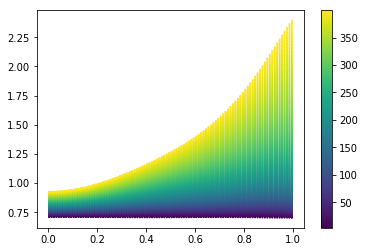

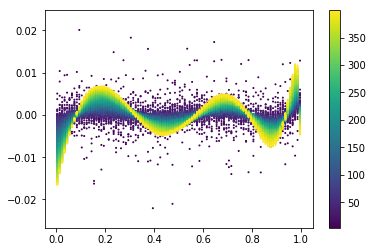

In [832]:
plt.scatter(mumu.ravel(),Phi_recon.ravel(),c=rr.ravel(),s=1);plt.colorbar();
plt.figure();
plt.scatter(mumu.ravel(),(Phi_true-Phi_recon).ravel(),c=rr.ravel(),s=1);plt.colorbar();

In [938]:
def phi_ell_model(r,*par):
    return par[0]+par[1]*r+par[2]*r**2.+par[3]*r**3.+par[4]*r**4.

In [940]:
all_par = []
for l_i in range(l_max//2+1):
    par,_=curve_fit(phi_ell_model,r_cen,Phi_multipoles[l_i],p0=[0 for _ in range(5)])
    all_par.append(par)
all_par=np.asarray(all_par)

In [941]:
def Phi_mu_model(r,mu,all_par):
    out = np.zeros([len(r),len(mu)])
    ells = np.arange(0.,l_max+2,2)
    all_leg = np.asarray([legendre(ell)(mu) for ell in ells])
    for i,r_i in enumerate(r):
        l_coeff = (all_par[:,0]+all_par[:,1]*r_i+all_par[:,2]*r_i**2.+all_par[:,3]*r_i**3.+all_par[:,4]*r_i**4.).reshape(-1,1)
        out[i,:]=np.sum(all_leg*l_coeff.reshape(-1,1),axis=0)
    return out

In [942]:
phi_model=Phi_mu_model(r_cen,mu_cen,all_par)

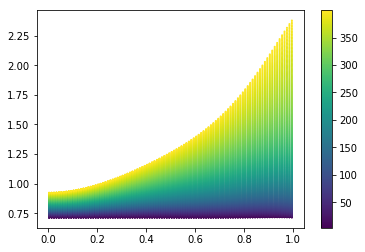

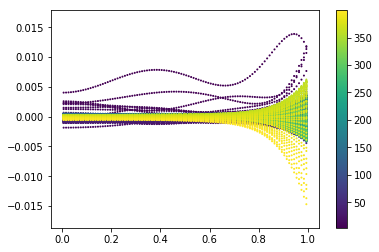

In [943]:
plt.scatter(mumu.ravel(),phi_model.ravel(),c=rr.ravel(),s=1);plt.colorbar();
plt.figure();
plt.scatter(mumu.ravel(),(phi_model-Phi_recon).ravel(),c=rr.ravel(),s=1);plt.colorbar();

In [950]:
np.savez('/mnt/store1/oliverphilcox/PowerSpectra/Phi_Correction_Multipoles.npz',multipole_coeff=all_par,ell=ells)

In [ ]:
def phi_ell_model(rmu_in,*par,ell=0):#a00,a10,a01,a11,a02,a03,a04,a21,a12,a30):
    r,mu=rmu_in
    #mu=np.log(1.1-mu)
    x=par[0]+par[1]*r+par[2]*mu+par[2]*r**2.+par[3]*mu**2.+par[4]*r*mu+par[5]*r*mu*mu+par[6]*r*r*mu
    y=x+par[7]*mu**3.+par[8]*r**3.+par[9]*r*mu**3.+par[10]*r**2.*mu**2.+par[11]*r**3.*mu+par[12]*mu**4.
    return y
    #mu=np.exp(mu)#mu=np.log(1.05-mu)#1.1-mu**2.)
    #return a00+a10*r+a01*mu+a11*r*mu+a02*mu*mu+a03*mu*mu*mu+0.*(a04*mu**4.+a12*mu*mu*r+a21*mu*r*r+a30*r*r*r)

In [638]:
RR_true = RR_flat.reshape((n+3,m))[3:,:]

In [639]:
mumu,rr = np.meshgrid(mu_cen,r_cen)

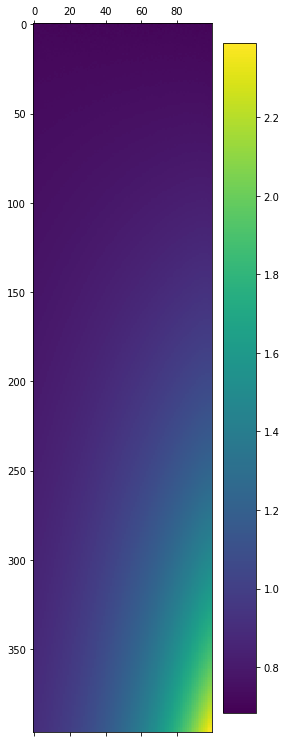

In [640]:
plt.matshow(RR_model(rr,mumu)/RR_true);
plt.colorbar();

In [641]:
Phi_vals = RR_model(rr,mumu)/RR_true

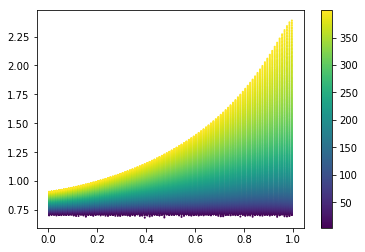

In [642]:
plt.scatter(mumu.ravel(),Phi_vals.ravel(),c=rr.ravel(),s=1);plt.colorbar();

In [643]:
from scipy.optimize import curve_fit

In [668]:
def phi_model(rmu_in,*par):#a00,a10,a01,a11,a02,a03,a04,a21,a12,a30):
    r,mu=rmu_in
    #mu=np.log(1.1-mu)
    x=par[0]+par[1]*r+par[2]*mu+par[2]*r**2.+par[3]*mu**2.+par[4]*r*mu+par[5]*r*mu*mu+par[6]*r*r*mu
    y=x+par[7]*mu**3.+par[8]*r**3.+par[9]*r*mu**3.+par[10]*r**2.*mu**2.+par[11]*r**3.*mu+par[12]*mu**4.
    return y
    #mu=np.exp(mu)#mu=np.log(1.05-mu)#1.1-mu**2.)
    #return a00+a10*r+a01*mu+a11*r*mu+a02*mu*mu+a03*mu*mu*mu+0.*(a04*mu**4.+a12*mu*mu*r+a21*mu*r*r+a30*r*r*r)

In [669]:
par,_=curve_fit(phi_model,[rr.ravel(),mumu.ravel()],Phi_vals.ravel(),p0=[0 for _ in range(13)])

In [670]:
all_pred = phi_model([rr.ravel(),mumu.ravel()],*par)

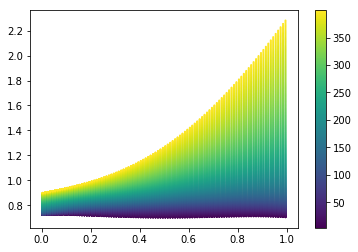

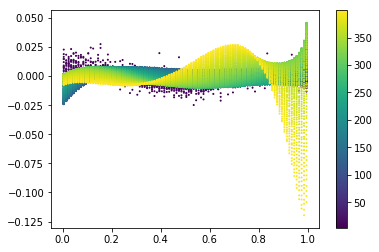

In [671]:
plt.scatter(mumu.ravel(),all_pred,c=rr.ravel(),s=1);plt.colorbar();
plt.figure()
plt.scatter(mumu.ravel(),all_pred-Phi_vals.ravel(),c=rr.ravel(),s=1);plt.colorbar();

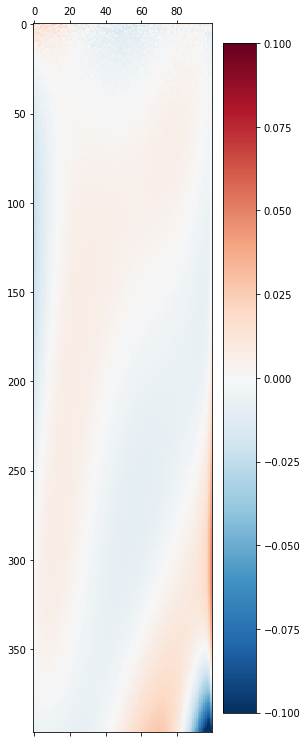

In [635]:
plt.matshow(all_pred.reshape(n,m)-Phi_vals,vmax=0.1,vmin=-0.1,cmap=cm.RdBu_r);plt.colorbar();

In [550]:
from scipy.interpolate import SmoothBivariateSpline
spl_phi=SmoothBivariateSpline(rr.ravel(),mumu.ravel(),Phi_vals.ravel())

In [551]:
plt.scatter(mumu.ravel(),spl_phi(rr.ravel(),mumu.ravel()),c=rr.ravel(),s=1);plt.colorbar();

ValueError: Error code returned by bispev: 10

In [552]:
def phi_model(r,mu,coeff,mu_crit=0.75):
    a0,a1,a2,b2,b3,c0,c1=coeff
    b1=a1+2*mu_crit*(a2-b2)-3*b3*mu_crit**2.
    b0=a0+(a1-b1)*mu_crit+(a2-b2)*mu_crit**2.-b3*mu_crit**3.
    filt1=np.where(mu<mu_crit)
    filt2=np.where(mu>=mu_crit)
    output=np.zeros_like(mu)
    output[filt1]=a0+a1*mu[filt1]+a2*mu[filt1]**2.
    output[filt2]=b0+b1*mu[filt2]+b2*mu[filt2]**2.+b3*mu[filt2]**3.
    return (c0+c1*r)*output    
    #a0,a1,a2,b0,b1,b2,b3=coeff
    #return (a0+a1*r+a2*r**2.)*(b0+b1*mu+b2*mu**2.+b3*mu**3.)
def phi_fit(coeff):
    model_vals = phi_model(rr.ravel(),mumu.ravel(),coeff)
    return np.sum((model_vals-Phi_vals.ravel())**2.)

In [553]:
from scipy.optimize import fmin
arg_out=fmin(phi_fit,[0,0,0,0,0,0,0])

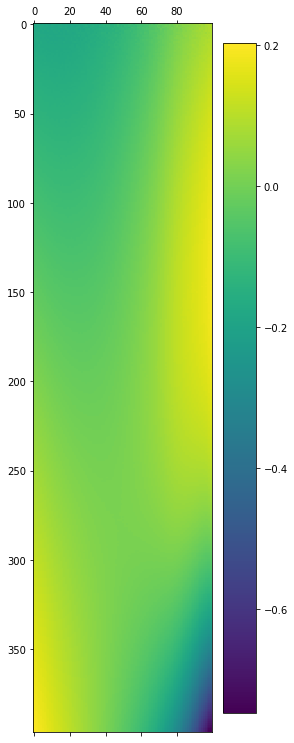

In [554]:
plt.matshow(phi_model(rr,mumu,arg_out)-Phi_vals);plt.colorbar();

#### Define RR model

In [38]:
def RR_model(r_cen,mu):
    return 4.*np.pi*V*(n_bar*w_bar)**2.*r_cen**2.*delta_r*delta_mu

In [39]:
all_ratios = [RR_true[:,i]/RR_model(r_cen,mu_cen[i]) for i in range(m)]
if np.mean(all_ratios)>10:
    raise Exception("RR_true seems to be much larger than RR_model. Is the input RR correctly normalized?")
if np.mean(all_ratios)<0.1:
    raise Exception("RR_true seems to be much larger than RR_model. Is the input RR correctly normalized?")

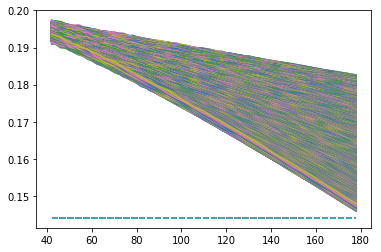

In [40]:
for i in range(m):
    plt.plot(r_cen,RR_true[:,i]/r_cen**2,ls='-')
    plt.plot(r_cen,RR_model(r_cen,mu_cen[i])/r_cen**2.,ls='--')

#### Find $\Phi$ functions

In [18]:
Phi_values = []
for r_bin in range(n):
    Phi_values.append(RR_model(r_cen[r_bin],mu_cen)/RR_true[r_bin,:])
    

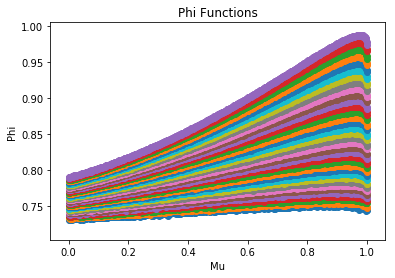

In [19]:
for i in range(n):
    plt.scatter(mu_cen,Phi_values[i]);
plt.title('Phi Functions')
plt.ylabel('Phi');plt.xlabel('Mu');

#### Fit to smooth function

Pick the piecewise continuous function;
$$\Phi(r_a,\mu) = \begin{cases} a_0+a_1\mu & \text{ if }\mu<0.75\\ b_0+b_1\mu+b_2\mu^2+b_3\mu^3 & \text{ if }\mu \geq 0.75\end{cases}$$
with $b_0$ and $b_1$ set by imposing that $\Phi$ and $d\Phi/d\mu$ are continuous at $\mu=0.75$.

In [462]:
mu_crit=0.75

In [463]:
def Phi_model(mu,a0,a1,a2,b2,b3,mu_crit=mu_crit):
    b1=a1+2*mu_crit*(a2-b2)-3*b3*mu_crit**2.
    b0=a0+(a1-b1)*mu_crit+(a2-b2)*mu_crit**2.-b3*mu_crit**3.
    filt1=np.where(mu<mu_crit)
    filt2=np.where(mu>=mu_crit)
    output=np.zeros_like(mu)
    output[filt1]=a0+a1*mu[filt1]+a2*mu[filt1]**2.
    output[filt2]=b0+b1*mu[filt2]+b2*mu[filt2]**2.+b3*mu[filt2]**3.
    return output

In [464]:
def fit_model(mu,good_param):
    return Phi_model(mu,good_param[0],good_param[1],good_param[2],good_param[3],good_param[4])

fit_params=[]
errors=[]
for i in range(n):
    good_param,_=curve_fit(Phi_model,mu_cen,Phi_values[i],p0=[0,0,0,0,0])
    a0,a1,a2,b2,b3=good_param
    b1=a1+2*mu_crit*(a2-b2)-3*b3*mu_crit**2.
    b0=a0+(a1-b1)*mu_crit+(a2-b2)*mu_crit**2.-b3*mu_crit**3.
    out_params=[a0,a1,a2,b0,b1,b2,b3]
    fit_params.append(out_params)
    errors.append(np.abs(Phi_values[i]-fit_model(mu_cen,good_param))/fit_model(mu_cen,good_param))
    

In [465]:
fit_params = np.asarray(fit_params)

Now save to file:

In [466]:
np.savetxt('/mnt/store1/oliverphilcox/Legendre2PCF/BinCorrectionFactor_n%d.txt'%n,fit_params)

### Do some graphical testing

In [467]:
test_index=20
good_param,_=curve_fit(Phi_model,mu_cen,Phi_values[test_index],p0=[0,0,0,0,0])

def fit_model(mu):
    return Phi_model(mu,good_param[0],good_param[1],good_param[2],good_param[3],good_param[4])

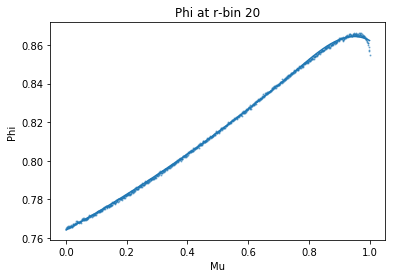

In [468]:
plt.plot(mu_cen,fit_model(mu_cen))
plt.scatter(mu_cen,Phi_values[test_index],alpha=0.5,s=1)
#plt.xlim([0.7,1])
plt.ylabel('Phi');plt.xlabel('Mu');plt.title('Phi at r-bin %d'%test_index);

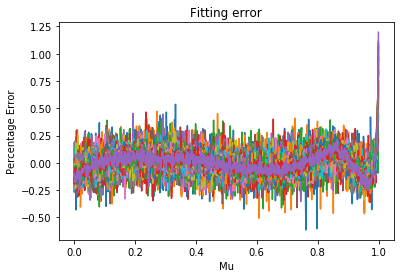

In [469]:
for i in range(n):
    good_param,_=curve_fit(Phi_model,mu_cen,Phi_values[i],p0=[0,0,0,0,0])

    def fit_model(mu):
        return Phi_model(mu,good_param[0],good_param[1],good_param[2],good_param[3],good_param[4])
    
    plt.plot(mu_cen,(fit_model(mu_cen)-Phi_values[i])/fit_model(mu_cen)*100.)
plt.title('Fitting error')
plt.xlabel('Mu')
plt.ylabel('Percentage Error');

In [470]:
d=np.loadtxt('/mnt/store1/oliverphilcox/Legendre2PCF/BinCorrectionFactor_n35_m1000.txt')